# LGU+ 경진대회 - 베이스라인  
- [Neural Collaborative Filtering(NCF)](https://arxiv.org/pdf/1708.05031.pdf) 논문의 NeuMF를 참고하여 side-information을 결합한 모델을 PyTorch로 구현
- 구현된 모델의 검증 데이터셋과 리더보드의 성능을 확인

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 목차 
- 데이터 전처리 
    - 기본 설정
    - 데이터 불러오기 
    - 학습 및 검증 데이터 생성 
- NeuMF 구현    
    - 모델 구현 
    - 학습 및 추론 코드 구현
- 모델 학습 
    - 하이퍼파라미터 설정 & 최적화 기법 설정
    - 모델 학습 
    - 학습 과정 시각화 
- 제출 
    - 모든 유저에 대해 추천 결과 생성
    - 저장 

## 데이터 전처리
### 기본 설정

In [2]:
# 패키지 로드
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm                            # tqdm.notebook은 version 5.0.0에서서 tqdm으로 통일됨
from sklearn.model_selection import train_test_split
from collections import defaultdict                       # key값이 없을 경우 미리 지정해 놓은 초기(default)값을 반환하는 dictionary
import os, random
from datetime import datetime
import re
from collections import Counter

from scipy import sparse                                  # 희소행렬. csr_matrix, linked list matrix 등...
from sklearn.preprocessing import LabelEncoder            # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn.init import normal_                         # Fills the input Tensor with values drawn from the normal distribution
from torch.utils.data import TensorDataset, DataLoader    # https://pytorch.org/docs/stable/data.html
import torch.nn.functional as F                           # https://pytorch.org/docs/stable/nn.functional.html

import plotnine                                           # R의 ggplot2를 파이썬에서 사용하는 라이브러리
from plotnine import *

from collections import Counter
import gensim
# import sentencepiece as spm

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
# 하이퍼파라미터 
class cfg: 
    gpu_idx = 0
    device = torch.device("cuda:{}".format(gpu_idx) if torch.cuda.is_available() else "cpu")
    top_k = 25
    seed = 42
    neg_ratio = 128
    test_size = 0.2

In [5]:
# 시드 고정
# https://rabo0313.tistory.com/entry/pytorch-torchmanualseed
def seed_everything(random_seed):
    torch.manual_seed(random_seed)              # Sets the seed for generating random numbers. Returns a torch.Generator object.
    torch.cuda.manual_seed(random_seed)         # Sets the seed for generating random numbers for the current GPU. It’s safe to call this function if CUDA is not available; in that case, it is silently ignored.
    torch.cuda.manual_seed_all(random_seed)     # Sets the seed for generating random numbers on all GPUs. It’s safe to call this function if CUDA is not available; in that case, it is silently ignored.
    torch.backends.cudnn.deterministic = True   # A bool that, if True, causes cuDNN to only use deterministic convolution algorithm
    torch.backends.cudnn.benchmark = False      # A bool that, if True, causes cuDNN to benchmark multiple convolution algorithms and select the fastest.
    np.random.seed(random_seed)
    random.seed(random_seed)
    
seed_everything(cfg.seed)

In [6]:
# 경로 설정
data_path = '/content/drive/MyDrive/01.Personal/01.study/02.AIFFEL/06.RecommendationSystem/03.U+/data'
saved_path = '/content/drive/MyDrive/01.Personal/01.study/02.AIFFEL/06.RecommendationSystem/03.U+/baseline_code'
output_path = '/content/drive/MyDrive/01.Personal/01.study/02.AIFFEL/06.RecommendationSystem/03.U+/submission'

### 데이터 불러오기
- history_data : 시청 시작 데이터
- watch_e_data : 시청 종료 데이터
- buy_data : 구매 이력 데이터
- search_data : 검색을 통한 시청 데이터
- meta_data : 콘텐츠 일반 메타 정보
- meta_data_plus : 콘텐츠 확장 정보
- profile_data : 프로필 정보 
- sample_submission : 리더보드 제출 양식

In [7]:
# 데이터 불러오기 
history_df = pd.read_csv(os.path.join(data_path, 'history_data.csv'), encoding='utf-8')
profile_df = pd.read_csv(os.path.join(data_path, 'profile_data.csv'), encoding='utf-8')
watch_df = pd.read_csv(os.path.join(data_path, 'watch_e_data.csv'), encoding='utf-8')
buy_df = pd.read_csv(os.path.join(data_path, 'buy_data.csv'), encoding='utf-8')
search_df = pd.read_csv(os.path.join(data_path, 'search_data.csv'), encoding='utf-8')
meta_df = pd.read_csv(os.path.join(data_path, 'meta_data.csv'), encoding='utf-8')
meta_data_plus_df = pd.read_csv(os.path.join(data_path, 'meta_data_plus.csv'), encoding='utf-8')
# sample_submission_df = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'), encoding='utf-8')

In [8]:
meta_data_plus_df
# meta_data_plus_df.nunique()

,album_id,keyword_type,keyword_name,keyword_value
0,749,05010101,시리즈,0
1,749,05010302,EBS,0
2,749,05010401,3세,0
3,749,05010402,4세,0
4,749,05010407,1세,0
...,...,...,...,...
767943,11629,05040104,신나는,0
767944,11629,0504010b,따라하고 싶은,0
767945,11629,05070e01,인체,0
767946,11629,05080401,캐릭터 친구들,0


In [9]:
# # Keyword_value가 5인 keyword_name 중 빈도수 높은 카테고리 테그만 적용

# # keyword_valve == 5
# meta_data_plus_temp_test = meta_data_plus_df[meta_data_plus_df.keyword_value == 5].copy()

# # counter
# word_list = [word for word in meta_data_plus_temp_test['keyword_name']]
# word_counter = Counter(word_list)

# word_list_sort = sorted(word_counter.items(), key=lambda x:x[1], reverse=True)
# subword_top20 = [(key, value) for key, value in word_list_sort[:20]]
# # # subword_top20
# # # word_list_sort

# meta_data_plus_temp = meta_data_plus_df.copy()
# meta_data_plus_temp['cnt'] = meta_data_plus_df['keyword_name'].apply(lambda x : word_counter[x])

# # keyword_name category 분류
# def replace_category(df):
#     idx = df[['cnt']].idxmax()
#     return int(idx)

# idx_list = []
# for alb_id in meta_data_plus_temp.album_id.unique():
#     idx = replace_category(meta_data_plus_temp[meta_data_plus_temp.album_id == alb_id])
#     idx_list.append(idx)

# category_temp = meta_data_plus_temp.loc[idx_list, ['album_id', 'keyword_name']]
# print(category_temp)
# print(category_temp.nunique())

# dict_temp = dict(category_temp.set_index('album_id'))

# meta_data_plus_df['keyword_name_update'] = meta_data_plus_df['album_id'].apply(lambda x : dict_temp['keyword_name'][x])

# meta_data_plus_df = meta_data_plus_df.merge(category_temp, how='left', on='album_id')
# meta_data_plus_df = meta_data_plus_df.rename(columns={'keyword_name_y':'keyword_name'})
# meta_data_plus_df = meta_data_plus_df[['album_id', 'keyword_type', 'keyword_name', 'keyword_value']]

In [10]:
# meta_data_plus_df.to_csv(os.path.join(data_path, 'meta_data_plus_temp_save.csv'), index=False)
meta_data_plus_df = pd.read_csv(os.path.join(data_path, 'meta_data_plus_temp_save.csv'), encoding='utf-8')

### 학습 및 검증 데이터 생성 
- train : 시청 이력의 80%를 사용 
- valid : 시청 이력의 20%를 사용 

In [11]:
# # Watch_ratio = time of watching / Total time
# data['watch_ratio'] = data[['watch_time', 'total_time']].apply(lambda x : x[0]/x[1], axis=1)
# data

data = history_df[['profile_id', 'log_time', 'album_id']].drop_duplicates(subset=['profile_id', 'album_id', 'log_time']).sort_values(by = ['profile_id', 'log_time']).reset_index(drop = True)

In [12]:
# 평점 추가하기
data['rating'] = 1                                         # 모두에게 기본 평점 1 설정
# data.loc[data['watch_ratio'] >= 0.9, 'rating'] += 1        # 시청시간이 0.9 이상이면 +1
# data.loc[data.payment.notnull(), 'rating'] += 1            # 지불한 사람 +1
# data.loc[data['continuous_play_y'] == 1, 'rating'] += 1    # continuou_play 연속재생한 사람 +1

In [13]:
# 학습 및 검증 데이터 분리
train, valid = train_test_split(
    data, test_size=cfg.test_size, random_state=cfg.seed
)
print('학습 데이터 크기:', train.shape)
print('검증 데이터 크기:', valid.shape)

학습 데이터 크기: (660490, 4)
검증 데이터 크기: (165123, 4)


In [14]:
# 필요한 컬럼만 뽑기 & sorting하기
train = train[['profile_id', 'log_time', 'album_id', 'rating']].sort_values(by = ['profile_id', 'log_time']).reset_index(drop = True)

# 유저, 아이템 최대 수
cfg.n_users = train.profile_id.max()+1
cfg.n_items = train.album_id.max()+1

In [15]:
# Matrix 형태로 변환 
train = train.to_numpy()
matrix = sparse.lil_matrix((cfg.n_users, cfg.n_items))    # 객체 생성, Row-based list of lists sparse matrix
                                                          # sparse.lil_matrix() : https://jisung0920.github.io/matrix%20representation/d058/
                                                          # matrix.__dict__ : 확인해봐라

########  데이터 컬럼 추가시 (p, _, i, r) 변경해야 할 것 #############################################################################
for (p, _, i, r) in tqdm(train):
    matrix[p, i] = r                                      # 각 유저가 시청한 아이템을 행렬로 표현 -> 결국 sparse matrix가 됨
# print('\nLinked List Matrix:\n', matrix.__dict__, '\n\n')

train = sparse.csr_matrix(matrix)                         # 객체 생성, csr_matrix() 설명 : https://matteding.github.io/2019/04/25/sparse-matrices/#compressed-sparse-rowcolumn
# print('\nCSR Matrix:\n', train.__dict__, '\n\n')          # train.__dict__ : 확인해봐라
        
train = train.toarray()
print("train 형태: \n", train)

  0%|          | 0/660490 [00:00<?, ?it/s]

train 형태: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


![image.png](attachment:7c4bfbc4-9352-496a-8644-e9b86ade4655.png)
![image.png](attachment:340666aa-c8a5-44f1-bc1e-61ec3227b2f1.png)

In [16]:
# 유저 특징 정보 추출 
profile_df = profile_df.set_index('profile_id')
user_features = profile_df[['age']].to_dict()               # key, val = profile_id, age
print("user_id 3의 age 정보 :", user_features['age'][3])      # 3번 user_id의 나이

user_id 3의 age 정보 : 5


In [17]:
# 아이템 특징 정보 추출 
meta_data_plus_df = meta_data_plus_df.set_index('album_id')
meta_df = meta_df.set_index('album_id')


# 범주형 데이터를 수치형 데이터로 변경 
# le_1 = LabelEncoder()                                                         # 객체 생성
le_2 = LabelEncoder()                                                         # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

meta_data_plus_df['keyword_name'] = le_2.fit_transform(meta_data_plus_df['keyword_name'])               # le.fit_transform 설명 : 라벨을 fit(인코딩 벡터)하고 들어오는 입력값에 대한 Transform을 함. 자세한 내용은 공식홈피 예시 참조 
# meta_df['genre_mid'] = le_1.fit_transform(meta_df['genre_mid'])

# meta_data_plus_df['keyword_name'] = le_2.fit_transform(meta_data_plus_df['keyword_name'])               # le.fit_transform 설명 : 라벨을 fit(인코딩 벡터)하고 들어오는 입력값에 대한 Transform을 함. 자세한 내용은 공식홈피 예시 참조 
# meta_df['genre_mid'] = le_1.fit_transform(meta_df['genre_mid'])

item_features_keyword_name = meta_data_plus_df[['keyword_name']].to_dict()                            # key, val = album_id, genre_mid_label
# item_features_genre_mid = meta_df[['genre_mid']].to_dict()

print("album_id 749의 keyword_name 정보 :", item_features_keyword_name['keyword_name'][749])
# print("album_id 749의 genre_mid 정보 :", item_features_genre_mid['genre_mid'][749])

album_id 749의 keyword_name 정보 : 49


In [18]:
# 추출한 특징 정보의 속성을 저장 
cfg.n_keyword_name = meta_data_plus_df['keyword_name'].nunique()  # keyword_name
# cfg.n_genre_mid = meta_df['genre_mid'].nunique()                  # genre
cfg.n_continuous_feats = 1                                        # age

## NeuMF 구현


### 모델 구현 
- [Neural Collaborative Filtering(NCF)](https://arxiv.org/pdf/1708.05031.pdf) 논문의 NeuMF를 참고하여 side-information을 결합한 모델을 PyTorch로 구현
    - continuous feature (age)와 categorical feature (genre_mid)를 같이 학습할 수 있도록 결합

![](http://drive.google.com/uc?export=view&id=1tpajTLipLoFdvLICO-alAxeoKAE8-k61)

In [19]:
class NeuMF(nn.Module):
    """Neural Matrix Factorization Model
        참고 문헌 : https://arxiv.org/abs/1708.05031

    예시 :
        model = NeuMF(cfg) 
        output = model.forward(user_ids, item_ids, [feat0, feat1]) 
    """
    def __init__(self, cfg):
        """ 
        Args:
            cfg : config 파일로 네트워크 생성에 필요한 정보들을 담고 있음 
        """
        super(NeuMF, self).__init__()
        self.n_users = cfg.n_users
        self.n_items = cfg.n_items
        self.emb_dim = cfg.emb_dim
        self.layer_dim = cfg.layer_dim
        self.n_continuous_feats = cfg.n_continuous_feats          # 베이스라인에서는 연속변수 age만 저장
        self.n_keyword_name = cfg.n_keyword_name                             # 베이스라인에서는 genre_mid의 개수를 저장했음
        # self.n_genre_mid = cfg.n_genre_mid
        self.dropout = cfg.dropout
        self.build_graph()                                        # 함수 호출 : DNN 레이어 설정

    def build_graph(self):
        """Neural Matrix Factorization Model 생성
            구현된 모습은 위의 그림을 참고 
        """
        self.user_embedding_mf = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)    # Embedding 설명 : https://wikidocs.net/64779 
        self.item_embedding_mf = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)
        
        self.user_embedding_mlp = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)
        self.item_embedding_mlp = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)
               
        # self.genre_embeddig = nn.Embedding(num_embeddings=self.n_genre_mid, embedding_dim=self.n_genre_mid//2)
        self.keyword_name_embeddig = nn.Embedding(num_embeddings=self.n_keyword_name, embedding_dim=self.n_keyword_name//2)
 
        
        
        self.mlp_layers = nn.Sequential(
            nn.Linear(2*self.emb_dim + self.n_keyword_name//2 + self.n_continuous_feats, self.layer_dim),  # 입력 레이어 들어갈 차원 총 개수(mlp user + mlp items + age + genre)
                                                                                                     # Applies a linear transformation to the incoming data
            nn.ReLU(),
            # nn.BatchNorm1d(self.layer_dim),  #1
            nn.Dropout(p=self.dropout),

            nn.Linear(self.layer_dim, self.layer_dim//2),  # 2
            # nn.BatchNorm1d(self.layer_dim//2), 
            nn.ReLU(), 
            nn.Dropout(p=self.dropout),

            # 3
            nn.Linear(self.layer_dim//2, self.layer_dim//2),
            # nn.BatchNorm1d(self.layer_dim//2),
            nn.ReLU(), 
            nn.Dropout(p=self.dropout),
            
            #4
            nn.Linear(self.layer_dim//2, self.layer_dim//4),
            nn.ReLU(), 
            nn.Dropout(p=self.dropout),
            
            #5
            nn.Linear(self.layer_dim//4, self.layer_dim//4),
            nn.ReLU(), 
            nn.Dropout(p=self.dropout),

            #6
            nn.Linear(self.layer_dim//4, self.layer_dim//4),
            nn.ReLU(), 
            nn.Dropout(p=self.dropout),

            #7
            nn.Linear(self.layer_dim//4, self.layer_dim//4),
            nn.ReLU(), 
            nn.Dropout(p=self.dropout),

            #8
            nn.Linear(self.layer_dim//4, self.layer_dim//8),
            nn.ReLU(), 
            nn.Dropout(p=self.dropout),

            #9
            nn.Linear(self.layer_dim//8, self.layer_dim//16),
            nn.ReLU(), 
            nn.Dropout(p=self.dropout),

            #10
            nn.Linear(self.layer_dim//16, self.layer_dim//16),
            nn.ReLU(), 
            nn.Dropout(p=self.dropout)

        )
        
        self.affine_output = nn.Linear(self.layer_dim//16 + self.emb_dim, 1) # 최종 출력값은 1개임
        self.apply(self._init_weights)                                      # _init_weights 함수 호출하여 가중치 초기화
        

    def _init_weights(self, module):
        if isinstance(module, nn.Embedding):
            normal_(module.weight.data, mean=0.0, std=0.01)
        elif isinstance(module, nn.Linear):
            normal_(module.weight.data, 0, 0.01)
            if module.bias is not None:
                module.bias.data.fill_(0.0)
                                                                                            
    ################ 이 선 위까지가 __init__으로 진행됨 #########################
                                              
                                              
    def forward(self, user_indices, item_indices, feats):
        """ 
        Args:
            user_indices : 유저의 인덱스 정보 
                ex) tensor([ 3100,  3100,  ..., 14195, 14195])
            item_indices : 아이템의 인덱스 정보
                ex) tensor([   50,    65,   ..., 14960, 11527])
            feats : 특징 정보 
        Returns: 
            output : 유저-아이템 쌍에 대한 추천 결과 
                ex) tensor([  9.4966,  22.0261, ..., -19.3535, -23.0212])
        """
        user_embedding_mf = self.user_embedding_mf(user_indices)
        item_embedding_mf = self.item_embedding_mf(item_indices)
        mf_output = torch.mul(user_embedding_mf, item_embedding_mf) # 아다마르곱 
        
        user_embedding_mlp = self.user_embedding_mlp(user_indices)
        item_embedding_mlp = self.item_embedding_mlp(item_indices)
        # genre_embedding_mlp = self.genre_embeddig(feats[1])                      # feats[1] : genre
        keyword_name_embedding_mlp = self.keyword_name_embeddig(feats[1])        # feats[2] : keyword_name
        input_feature = torch.cat((user_embedding_mlp, item_embedding_mlp, keyword_name_embedding_mlp, feats[0].unsqueeze(1)), -1)  # unsqueeze 설명 : 아래 사진
                                                                                                                             # torch.cat 주의사항 : All tensors must either have the same shape (except in the concatenating dimension) or be empty.
                                                                                                                             # feats[0] : age

                                                                                                                              
        mlp_output = self.mlp_layers(input_feature)
        
        output = torch.cat([mlp_output, mf_output], dim=-1)
        output = self.affine_output(output).squeeze(-1)  # torch.squeeze : Returns a tensor with all the dimensions of input of size 1 removed
                                                         # https://pytorch.org/docs/stable/generated/torch.squeeze.html
        return output

![image.png](attachment:febca1e4-b0f9-4dc4-bb18-95f07e3b469f.png)

### torch.unsqueeze()
![image.png](attachment:8227f8a1-5d57-4f91-bb41-f21a8c95d14c.png)
- 주의: 차원을 하나 추가하는 것이지 추가한 차원에 1 또는 임의의 수를 채우는 것은 아님

### torch.cat()
![image.png](attachment:3a142270-5d71-4446-96dc-80a5fa5f197d.png)

### torch.squeeze()
![image.png](attachment:4d7d4a6a-8b1b-4609-8517-0b3e4e0f05ae.png)

### 학습 및 추론 코드 구현

- 학습 : Negative sampling을 활용하여 Binary Classification 진행 
    - history 에 있는 album_id는 positive label로 그렇지 않은 album_id는 nagative label로 활용  
    - 단, 이때 모든 album_id를 negative label로 활용하는 것이 아닌 일부만 사용 (neg_ratio 값에 따라서 개수 조정)
- 추론 : 일부 데이터에 대해 recall, ndcg, coverage 성능 확인

#### 학습 및 추론에 필요한 데이터 셋 생성 코드 구현

In [20]:
# 유저별 학습에 필요한 딕셔너리 데이터 생성 
def make_UIdataset(train, neg_ratio):
    """ 유저별 학습에 필요한 딕셔너리 데이터 생성 
    Args:
        train : 유저-아이템의 상호작용을 담은 행렬
            ex) 
                array([[0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        ...,
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.]])
        neg_ratio : negative sampling 활용할 비율 
            ex) 3 (positive label 1개당 negative label 3개)
    Returns: 
        UIdataset : 유저별 학습에 필요한 정보를 담은 딕셔너리 
            ex) {'사용자 ID': [[positive 아이템 index들, negative 아이템 index들],[User_feature들], [Item_feature들], [Label들... 1, 1, 1, ..., 0, 0]]}  총 4개의 리스트
                >>> UIdataset[3]
                    [array([   16,    17,    18, ...,  9586, 18991,  9442]),  # [positive 아이템 index들, negative 아이템 index들]
                    array([5, 5, 5, ..., 5, 5, 5]),                           # [User_feature들]
                    array([4, 4, 4, ..., 5, 1, 1]),                           # [Item_feature들]
                    array([1., 1., 1., ..., 0., 0., 0.])]                     # [Label들]
    """
    UIdataset = {}
    for user_id, items_by_user in enumerate(train):
        UIdataset[user_id] = []              # 해당 유저 정보를 담을 빈 리스트 생성   
        
        # positive 샘플 계산 
        pos_item_ids = np.where(items_by_user > 0.5)[0]      # 평점이 0.5 초과이면 해당 인덱스를 반환. 즉, history_df에서 해당 유저가 해당 아이템을 봤으면 positive label 부여
                                                             # np.where(조건) : 조건에 만족하는 index를 반환 
                                                             # np.where -> np.nonzero : https://numpy.org/doc/stable/reference/generated/numpy.nonzero.html#numpy.nonzero
                                                             # https://stackoverflow.com/questions/4588628/find-indices-of-elements-equal-to-zero-in-a-numpy-array
                                                             # np.where 결과 shpae : 1차원
        num_pos_samples = len(pos_item_ids)

        # negative 샘플 계산 (random negative sampling) 
        num_neg_samples = neg_ratio * num_pos_samples
        neg_items = np.where(items_by_user < 0.5)[0]         # np.where 결과 shpae : 1차원
        neg_item_ids = np.random.choice(neg_items, min(num_neg_samples, len(neg_items)), replace=False)  # np.random.choice : https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
        UIdataset[user_id].append(np.concatenate([pos_item_ids, neg_item_ids]))                          # np.concatenate : https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html
                                                                                                         # axix=0 is default
                                                                                                         # array([positive labels, negative labes])
        
        # feature 추출 
        # 유저 feature 추출
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]):  # 의미없는 for문......
            features.append(user_features['age'][user_id])            # 유저 나이
        UIdataset[user_id].append(np.array(features))
        
#         # item feature 추출
#         features = []
#         for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
#             features.append(item_features_genre_mid['genre_mid'][item_id])           # keyword_name_label
# #             features.append(item_features_keyword_name['keyword_name'][item_id])     # keyword_name_label
#         UIdataset[user_id].append(np.array(features))
        
        # item feature 추출
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
#             features.append(item_features_genre_mid['genre_mid'][item_id])           # keyword_name_label
            features.append(item_features_keyword_name['keyword_name'][item_id])     # keyword_name_label
        UIdataset[user_id].append(np.array(features))
        
        # label 저장  
        pos_labels = np.ones(len(pos_item_ids))
        neg_labels = np.zeros(len(neg_item_ids))
        UIdataset[user_id].append(np.concatenate([pos_labels, neg_labels]))

    return UIdataset

### min(arg1, arg2, ...)
![image.png](attachment:741893b5-64a2-448f-8e64-e5f0883ccac4.png)

### np.concatenate((a, b), axis=0)
![image.png](attachment:e5b95790-2792-4d7a-83db-36e8eecc2d0f.png)


In [21]:
UIdataset = make_UIdataset(train, neg_ratio=cfg.neg_ratio) # neg_ratio = 100

In [22]:
def make_batchdata(user_indices, batch_idx, batch_size):
    """ 배치 데이터로 변환 
    Args:
        user_indices : 전체 유저의 인덱스 정보 
            ex) array([ 3100,  1800, 30098, ...,  2177, 11749, 20962])
        batch_idx : 배치 인덱스 (몇 번째 배치인지)
            ex) 0 
        batch_size : 배치 크기 
            ex) 256 
    Returns 
        batch_user_ids : 배치 내의 유저 인덱스 정보 
            ex) [22194, 22194, 22194, 22194, 22194, ...]
        batch_item_ids : 배치 내의 아이템 인덱스 정보 
            ex) [36, 407, 612, 801, 1404, ...]
        batch_feat0 : 배치 내의 유저-아이템 인덱스 정보에 해당하는 feature0 정보 
            ex) [6, 6, 6, 6, 6, ...]
        batch_feat1 : 배치 내의 유저-아이템 인덱스 정보에 해당하는 feature1 정보 
            ex) [4,  4,  4, 23,  4, ...]
        batch_labels : 배치 내의 유저-아이템 인덱스 정보에 해당하는 label 정보 
            ex) [1.0, 1.0, 1.0, 1.0, 1.0, ...]
    """
    # make_UIdataset 함수 확인하면 이해하기 쉽다
    batch_user_indices = user_indices[batch_idx*batch_size : (batch_idx+1)*batch_size]
    batch_user_ids = []
    batch_item_ids = []
    batch_feat0 = []        # 유저 특징. 베이스라인에서는 age
    # batch_feat1 = []        # genre_mid
    batch_feat2 = []        # keyword_name
    batch_labels = []       # 라벨 [positive label들, negative label들]
    for user_id in batch_user_indices:
        item_ids = UIdataset[user_id][0]                  # [positive 아이템 index들, negative 아이템 index들]
        feat0 = UIdataset[user_id][1]                     # [User_feature들]
        # feat1 = UIdataset[user_id][2]                     # [Item_feature들] genre_mid
        feat2 = UIdataset[user_id][2]                     # [Item_feature들] keyword_name
        labels = UIdataset[user_id][3]                    # [Label들]
        user_ids = np.full(len(item_ids), user_id)        # np.full : Return a new array of given shape and type, filled with `fill_value`
                                                          # 예를 들어 user_id 3인 유저가 5개의 아이템에 평점을 내렸다면 array([3,3,3,3,3])이 됨
        batch_user_ids.extend(user_ids.tolist())
        batch_item_ids.extend(item_ids.tolist())
        batch_feat0.extend(feat0.tolist())
        # batch_feat1.extend(feat1.tolist())
        batch_feat2.extend(feat2.tolist())
        batch_labels.extend(labels.tolist())
    return batch_user_ids, batch_item_ids, batch_feat0, batch_feat2, batch_labels


# 현재까지 측정한 평균값은 아는데 새로운 변수 값이 추가되면 새로운 평균값은 뭔가? https://ospace.tistory.com/200
def update_avg(curr_avg, val, idx):
    """ 
    현재 epoch 까지의 평균 값을 계산 
    """
    return (curr_avg * idx + val) / (idx + 1)

#### 학습 및 검증 코드 생성

In [23]:
def train_epoch(cfg, model, optimizer, criterion): 
    model.train()
    curr_loss_avg = 0.0

    user_indices = np.arange(cfg.n_users)
    np.random.RandomState(cfg.epoch).shuffle(user_indices)        
    batch_num = int(len(user_indices) / cfg.batch_size) + 1
    bar = tqdm(range(batch_num), leave=False)
    for step, batch_idx in enumerate(bar):
        user_ids, item_ids, feat0, feat2, labels = make_batchdata(user_indices, batch_idx, cfg.batch_size)
        # 배치 사용자 단위로 학습
        user_ids = torch.LongTensor(user_ids).to(cfg.device)     # torch.LongTensor : signed 64-bit integer(CPU Tensor)
                                                                 # torch.tensor.to() : https://pytorch.org/docs/stable/generated/torch.Tensor.to.html?highlight=#torch.Tensor.to
                                                                 # https://wikidocs.net/52846
        item_ids = torch.LongTensor(item_ids).to(cfg.device)
        feat0 = torch.FloatTensor(feat0).to(cfg.device)
        # feat1 = torch.LongTensor(feat1).to(cfg.device)
        feat2 = torch.LongTensor(feat2).to(cfg.device)
        labels = torch.FloatTensor(labels).to(cfg.device)
        labels = labels.view(-1, 1)                              # pytorch의 view는 numpy의 reshape 역할

        # gradient 초기화
        optimizer.zero_grad()                                    # 학습 loop를 돌때 이상적으로 학습이 이루어지기 위해선 한번의 학습이 완료되어지면(즉, Iteration이 한번 끝나면) gradients를 항상 0으로 만들어 주어야 합니다. 
                                                                 # 만약 gradients를 0으로 초기화해주지 않으면 gradient가 의도한 방향이랑 다른 방향을 가르켜 학습이 원하는 방향으로 이루어 지지 않습니다
                                                                 # https://algopoolja.tistory.com/55
                                                                 # https://yeko90.tistory.com/entry/파이토치-기초-modelzerograd-optimizerzerograd-쓰는-이유

        # 모델 forward
        output = model.forward(user_ids, item_ids, [feat0, feat2])
        output = output.view(-1, 1)                              # pytorch의 view는 numpy의 reshape 역할

        # 손실함수
        loss = criterion(output, labels)       

        # 역전파
        loss.backward()

        # 최적화         
        optimizer.step()                                         # Performs a single optimization step (parameter update).                         
                                                                 # torch.optim.optimizer.step : https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html#torch.optim.Optimizer.step
        if torch.isnan(loss):                                    # https://pytorch.org/docs/stable/generated/torch.isnan.html
            print('Loss NAN. Train finish.')
            break
        curr_loss_avg = update_avg(curr_loss_avg, loss, step)    # 현재 평균이 얼마인지 계산
        
        msg = f"epoch: {cfg.epoch}, "
        msg += f"loss: {curr_loss_avg.item():.5f}, "
        msg += f"lr: {optimizer.param_groups[0]['lr']:.6f}"
        bar.set_description(msg)                                # set a description for your progress bar when using tqdm,
    rets = {'losses': np.around(curr_loss_avg.item(), 5)}       # np.around : 반올림 https://numpy.org/doc/stable/reference/generated/numpy.around.html
    return rets

In [24]:
def recallk(actual, predicted, k = 25):
    """ label과 prediction 사이의 recall 평가 함수 
    Args:
        actual : 실제로 본 상품 리스트
        pred : 예측한 상품 리스트
        k : 상위 몇개의 데이터를 볼지 (ex : k=5 상위 5개의 상품만 봄)
    Returns: 
        recall_k : recall@k 
    """ 
    set_actual = set(actual)
    recall_k = len(set_actual & set(predicted[:k])) / min(k, len(set_actual))
    return recall_k

def unique(sequence):
    # preserves order
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

def ndcgk(actual, predicted, k = 25):
    set_actual = set(actual)
    idcg = sum([1.0 / np.log(i + 2) for i in range(min(k, len(set_actual)))])
    dcg = 0.0
    unique_predicted = unique(predicted[:k])
    for i, r in enumerate(unique_predicted):
        if r in set_actual:
            dcg += 1.0 / np.log(i + 2)
    ndcg_k = dcg / idcg
    return ndcg_k

def evaluation(gt, pred):
    """ label과 prediction 사이의 recall, coverage, competition metric 평가 함수 
    Args:
        gt : 데이터 프레임 형태의 정답 데이터 
        pred : 데이터 프레임 형태의 예측 데이터 
    Returns: 
        rets : recall, ndcg, coverage, competition metric 결과 
            ex) {'recall': 0.123024, 'ndcg': 056809, 'coverage': 0.017455, 'score': 0.106470}
    """    
    gt = gt.groupby('profile_id')['album_id'].unique().to_frame().reset_index()
    gt.columns = ['profile_id', 'actual_list']

    evaluated_data = pd.merge(pred, gt, how = 'left', on = 'profile_id')

    evaluated_data['Recall@25'] = evaluated_data.apply(lambda x: recallk(x.actual_list, x.predicted_list), axis=1)  # pd.apply() : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
    evaluated_data['NDCG@25'] = evaluated_data.apply(lambda x: ndcgk(x.actual_list, x.predicted_list), axis=1)

    recall = evaluated_data['Recall@25'].mean()
    ndcg = evaluated_data['NDCG@25'] .mean()
    coverage = (evaluated_data['predicted_list'].apply(lambda x: x[:cfg.top_k]).explode().nunique())/meta_df.index.nunique()

    score = 0.75*recall + 0.25*ndcg
    rets = {"recall" :recall, 
            "ndcg" :ndcg, 
            "coverage" :coverage, 
            "score" :score}
    return rets

In [25]:
def valid_epoch(cfg, model, data, mode='valid'):
    pred_list = []
    model.eval()     # https://bluehorn07.github.io/2021/02/27/model-eval-and-train.html
                     # model.eval() : https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch/60018731#60018731
    
    query_user_ids = data['profile_id'].unique() # 추론할 모든 user array 집합
    full_item_ids = np.array([c for c in range(cfg.n_items)]) # 추론할 모든 item array 집합 
    # full_item_ids_feat1 = [item_features_genre_mid['genre_mid'][c] for c in full_item_ids]       # keyword_name
    full_item_ids_feat2 = [item_features_keyword_name['keyword_name'][c] for c in full_item_ids] # genre
    for user_id in query_user_ids:
        with torch.no_grad():          #  turn off gradients computation : https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch/60018731#60018731
            user_ids = np.full(cfg.n_items, user_id)
            
            user_ids = torch.LongTensor(user_ids).to(cfg.device)
            item_ids = torch.LongTensor(full_item_ids).to(cfg.device)
            
            feat0 = np.full(cfg.n_items, user_features['age'][user_id])
            feat0 = torch.FloatTensor(feat0).to(cfg.device)
            # feat1 = torch.LongTensor(full_item_ids_feat1).to(cfg.device)
            feat2 = torch.LongTensor(full_item_ids_feat2).to(cfg.device)
            
            eval_output = model.forward(user_ids, item_ids, [feat0, feat2]).detach().cpu().numpy()
            pred_u_score = eval_output.reshape(-1)   
        
        pred_u_idx = np.argsort(pred_u_score)[::-1]
        pred_u = full_item_ids[pred_u_idx]
        pred_list.append(list(pred_u[:cfg.top_k]))
        
    pred = pd.DataFrame()
    pred['profile_id'] = query_user_ids
    pred['predicted_list'] = pred_list
    
    # 모델 성능 확인 
    if mode == 'valid':
        rets = evaluation(data, pred)
        return rets, pred
    return pred

## 모델 학습

### 하이퍼파라미터 설정 & 최적화 기법 설정

In [26]:
# 하이퍼 파라미터 설정 
cfg.batch_size = 128  # 512
cfg.emb_dim = 512
cfg.layer_dim = 512   # 1024
cfg.dropout = 0.05    # 0.03
cfg.epochs = 25
cfg.learning_rate = 0.001  # 0.001
cfg.reg_lambda = 0
cfg.check_epoch = 5

In [27]:
# model 생성 및 optimizer, loss 함수 설정 
model = NeuMF(cfg).to(cfg.device)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate, weight_decay=cfg.reg_lambda)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=cfg.learning_rate, weight_decay=cfg.reg_lambda)

criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')           # Binary Cross Entropy(BCEwithLogitsloss) : https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html

### 학습 진행

In [28]:
total_logs = defaultdict(list)
best_scores  = 0
for epoch in range(cfg.epochs+1):
    cfg.epoch = epoch
    
    # 학습
    train_results = train_epoch(cfg, model, optimizer, criterion)
    
    # cfg.check_epoch 번의 epoch 마다 성능 확인 
    if epoch % cfg.check_epoch == 0: 
        valid_results, _ = valid_epoch(cfg, model, valid)

        logs = {
            'Train Loss': train_results['losses'],
            f'Valid Recall@{cfg.top_k}': valid_results['recall'],
            f'Valid NDCG@{cfg.top_k}': valid_results['ndcg'],
            'Valid Coverage': valid_results['coverage'],
            'Valid Score': valid_results['score'],
            }

        # 검증 성능 확인 
        for key, value in logs.items():
            total_logs[key].append(value)

        if epoch == 0:
            print("Epoch", end=",")
            print(",".join(logs.keys()))

        print(f"{epoch:02d}  ", end="")                      # f"{:02d}" : 02d formats an integer (d) to a field of minimum width 2 (2), with zero-padding on the left (leading 0):
        print("  ".join([f"{v:0.6f}" for v in logs.values()]))
        
        # 가장 성능이 좋은 가중치 파일을 저장 
        if best_scores <= valid_results['score']: 
            best_scores = valid_results['score']
            torch.save(model.state_dict(), os.path.join(saved_path, 'model(best_scores).pth'))

  0%|          | 0/259 [00:00<?, ?it/s]

Epoch,Train Loss,Valid Recall@25,Valid NDCG@25,Valid Coverage,Valid Score
00  14627.425780  0.164493  0.119740  0.001455  0.153305


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

05  2030.336300  0.491670  0.356212  0.202157  0.457806


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

10  442.363530  0.513974  0.362197  0.375097  0.476030


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

15  98.646640  0.513584  0.363872  0.381116  0.476156


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

20  28.254040  0.511054  0.361594  0.381918  0.473689


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

25  10.971870  0.509213  0.360117  0.393053  0.471939


### 학습 과정 시각화

In [29]:
train_scores = pd.DataFrame({'Train loss': total_logs['Train Loss']})
train_scores['Epoch'] = range(0, cfg.epochs+1, cfg.check_epoch)

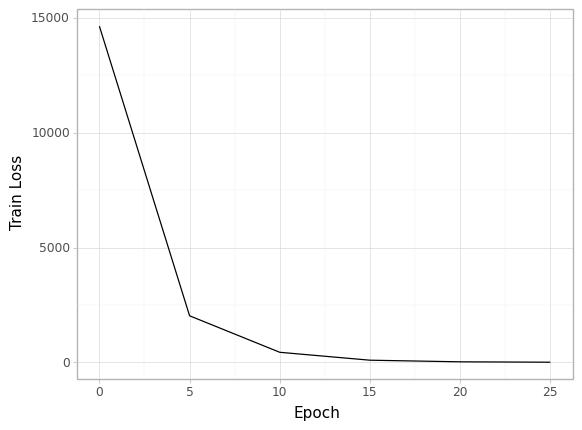

<ggplot: (8731710487935)>

In [30]:
(
    ggplot(train_scores, aes(x='Epoch', y='Train loss'))
        + geom_line(color='black') # line plot
        + labs(x='Epoch', y='Train Loss')
        + theme_light()
)

In [31]:
valid_scores = pd.DataFrame(np.hstack([(range(0, cfg.epochs+1, cfg.check_epoch), total_logs[score], [score for i in range(0, cfg.epochs+1, cfg.check_epoch)]) for score in ['Valid Recall@25', 'Valid NDCG@25', 'Valid Coverage', 'Valid Score']])).T
valid_scores.columns = ['Epoch', 'Score', 'Metric']
valid_scores['Epoch'] = valid_scores['Epoch'].astype(int)
valid_scores['Score'] = valid_scores['Score'].astype(float)

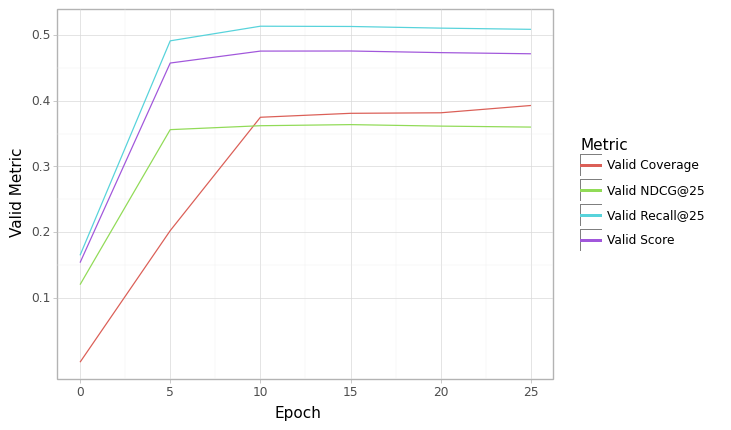

<ggplot: (8731758718717)>

In [32]:
(
ggplot(valid_scores)  # here
    + aes("Epoch", "Score", color='Metric', group='Metric')
    + geom_line()
    + scale_y_continuous(breaks=[0.1*c for c in range(1, 10, 1)])
    + theme_light()
    + labs(x='Epoch', y='Valid Metric')
)  

## 제출 
### 모든 유저에 대해 추천 결과 생성

In [33]:
model.load_state_dict(torch.load(os.path.join(saved_path, 'model(best_scores).pth')))

<All keys matched successfully>

In [34]:
submission_path = os.path.join(data_path, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission = valid_epoch(cfg, model, submission, mode='test')

### 저장

In [35]:
submission.to_csv(os.path.join(output_path, 'submission_3.csv'), index = False)

In [36]:
print(submission)

      profile_id                                     predicted_list
0              3  [16, 15, 17, 19, 18, 38, 224, 31, 241, 32, 21,...
1              5  [38, 136, 42, 269, 124, 16, 128, 265, 272, 168...
2              7  [343, 241, 55, 1880, 329, 38, 347, 383, 16, 12...
3             12  [356, 357, 353, 352, 355, 124, 424, 127, 125, ...
4             16  [124, 339, 65, 125, 190, 127, 241, 2029, 329, ...
...          ...                                                ...
8306       33022  [188, 1425, 1426, 1005, 56, 16, 36, 15, 1447, ...
8307       33023  [65, 190, 1888, 124, 339, 125, 2272, 241, 2331...
8308       33026  [6772, 6774, 3255, 68, 6773, 6778, 6779, 6761,...
8309       33027  [51, 50, 126, 125, 124, 127, 65, 339, 2029, 24...
8310       33032  [349, 14665, 1737, 190, 124, 7010, 7105, 339, ...

[8311 rows x 2 columns]
